In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn

In [ ]:
!pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f06f4a1d59c47123d38284fd7e6a600997bd1decd860b63de488b529f0b06eba
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Loading and preparing train data...
Loading and preparing dev and test data...

Combined dev and test sets into a single final test set of 29517 sentences.

Preparing data for HMM...


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Vocabulary size: 17210
Processed 126169 training sentences for HMM.

Starting model training with HMM...


         1       0.00000000             +nan
         2       0.00000000      -0.00000000



--- Detailed Evaluation on Combined Test Set (HMM) ---


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Final Test Set Classification Report:
Entity                Precision     Recall   F1-Score    Support
-----------------------------------------------------------------
EMOJI_CAMO               0.0430     0.1133     0.0623       4113
EMOJI_CHAR_CAMO          0.0035     0.0171     0.0058       6189
INV_CAMO                 0.0036     0.1559     0.0070        680
LEETSPEAK                0.0000     0.0000     0.0000       5457
MIX_CAMO                 0.0000     0.0000     0.0000       6539
PUNCT_CAMO               0.0000     0.0000     0.0000       6539
-----------------------------------------------------------------
Accuracy                                        0.0054
Overall (Micro Avg)      0.0063     0.0230     0.0099

Confusion matrix saved to: /content/drive/My Drive/Vidath/traditional_model/HMM/hmm_final_confusion_matrix.png


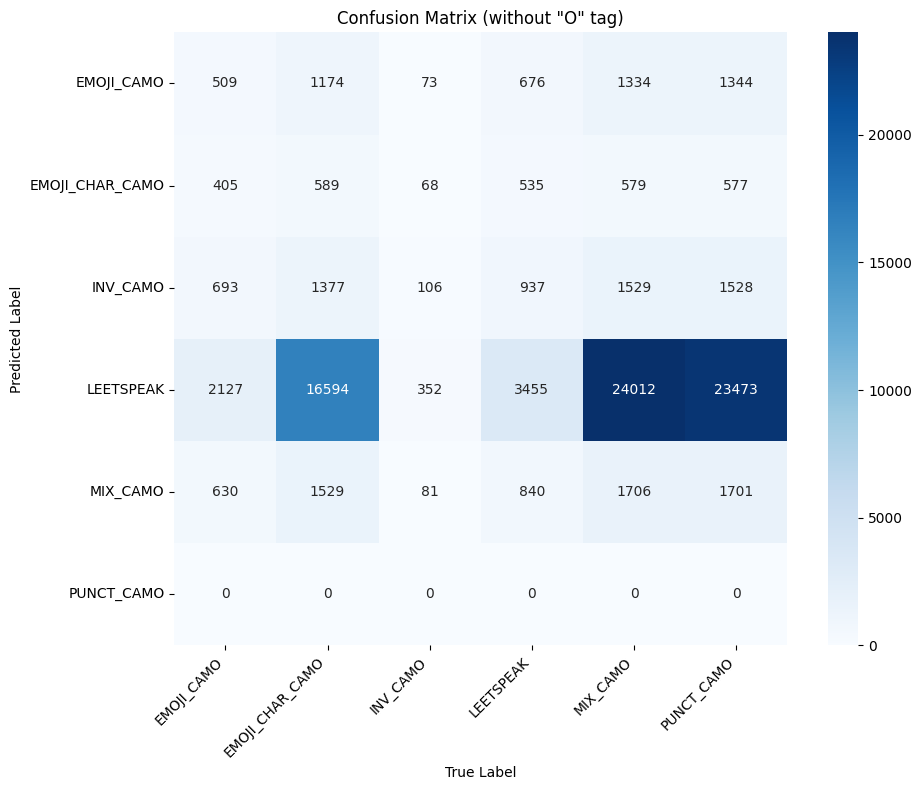

Metrics bar chart saved to: /content/drive/My Drive/Vidath/traditional_model/HMM/hmm_final_metrics_barchart.png


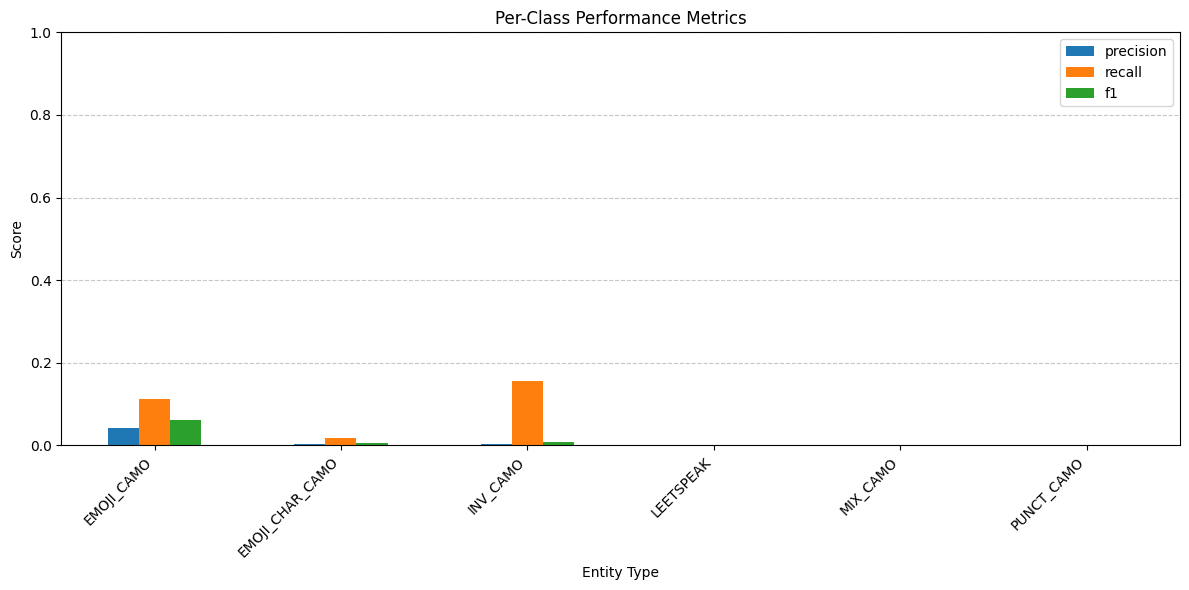


Model bundle saved to /content/drive/My Drive/Vidath/traditional_model/HMM/hmm-ner-model-bundle.joblib


In [ ]:
# 0. Install hmmlearn
try:
    import hmmlearn
except ImportError:
    print("Installing hmmlearn...")
    import subprocess
    subprocess.check_call(["pip", "install", "hmmlearn"])
    from hmmlearn import hmm

# 1. Imports and Setup
import pandas as pd
import numpy as np
import re
from hmmlearn import hmm
from collections import Counter
from sklearn.metrics import confusion_matrix
from evaluate import load
import joblib
import os

### --- Imports for visualization --- ###
import matplotlib.pyplot as plt
import seaborn as sns

# Need seqeval for metric computation
try:
    from evaluate import load
    load("seqeval")
except ImportError:
    print("Installing seqeval and evaluate...")
    import subprocess
    subprocess.check_call(["pip", "install", "evaluate", "seqeval"])
    from evaluate import load

# 2. Labels (No changes needed)
BASE_LABELS = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]
LABEL_LIST = ["O"] + [f"B-{label}" for label in BASE_LABELS] + [f"I-{label}" for label in BASE_LABELS]

# --- Data Loading Function (No changes needed) ---
def load_and_prepare_data_hmm(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')
    grouped = df.groupby('Text').apply(lambda x: x.to_dict('records'), include_groups=False).reset_index(name='entities')
    sentences = []
    for _, row in grouped.iterrows():
        text = str(row['Text']) if pd.notna(row['Text']) else ""
        entities = row['entities']
        tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
        tokens = [t[0] for t in tokens_with_spans]
        labels = ['O'] * len(tokens)
        for entity in entities:
            ent_start, ent_end, ent_label = entity['Start'], entity['End'], entity['Label']
            if f"B-{ent_label}" not in LABEL_LIST: continue
            in_entity = False
            for i, (token, tok_start, tok_end) in enumerate(tokens_with_spans):
                if max(tok_start, ent_start) < min(tok_end, ent_end):
                    labels[i] = f"B-{ent_label}" if not in_entity else f"I-{ent_label}"
                    in_entity = True
                else: in_entity = False
        sentences.append((tokens, labels))
    return sentences

# 3. Data Loading
print("Loading and preparing train data...")
train_sents = load_and_prepare_data_hmm("/content/drive/My Drive/Vidath/Dataset/augmented_train_all_combo_emoji.csv")
print("Loading and preparing dev and test data...")
dev_sents = load_and_prepare_data_hmm("/content/drive/My Drive/Vidath/Dataset/augmented_dev_all_combo_emoji.csv")
test_sents = load_and_prepare_data_hmm("/content/drive/My Drive/Vidath/Dataset/augmented_test_all_combo_emoji.csv")
combined_test_sents = dev_sents + test_sents
print(f"\nCombined dev and test sets into a single final test set of {len(combined_test_sents)} sentences.")

# --------------------------------------------------------------------------
# --- HMM-Specific Data Preparation ---
# --------------------------------------------------------------------------
print("\nPreparing data for HMM...")

# Step 1: Create vocabularies and mappings
all_tokens = [token for sent, _ in train_sents for token in sent]
word_counts = Counter(all_tokens)

# Replace rare words with <UNK> token to handle unknown words during testing
# Words that appear only once will be considered unknown
vocab = {word for word, count in word_counts.items() if count > 1}
vocab.add("<UNK>")

word_to_id = {word: i for i, word in enumerate(vocab)}
label_to_id = {label: i for i, label in enumerate(LABEL_LIST)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Step 2: Convert data to integer sequences
X_train, y_train, train_lengths = [], [], []
for sent, labels in train_sents:
    X_train.extend([word_to_id.get(w, word_to_id["<UNK>"]) for w in sent])
    y_train.extend([label_to_id[l] for l in labels])
    train_lengths.append(len(sent))

X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)

print(f"Vocabulary size: {len(vocab)}")
print(f"Processed {len(train_sents)} training sentences for HMM.")

# 4. Model Training
print("\nStarting model training with HMM...")
hmm_model = hmm.MultinomialHMM(n_components=len(LABEL_LIST), n_iter=100, tol=1e-4, random_state=42, verbose=True)
hmm_model.fit(X_train, lengths=train_lengths)

# 5. Evaluation and Reporting Functions (The plotting/reporting functions are reusable)
def print_classification_report(report_dict):
    print(f"{'Entity':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 65)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):
            name, precision, recall, support = label, metrics.get('precision', 0), metrics.get('recall', 0), metrics.get('number', 0)
            f1 = metrics.get('f1', 0)
            print(f"{name:<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10}")
    print("-" * 65)
    precision, recall, f1, accuracy = report_dict.get('overall_precision', 0), report_dict.get('overall_recall', 0), report_dict.get('overall_f1', 0), report_dict.get('overall_accuracy', 0)
    print(f"{'Accuracy':<20} {accuracy:>33.4f}")
    print(f"{'Overall (Micro Avg)':<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}\n")

def aggregate_bio_tags(labels): return [label[2:] if label not in ['O'] else 'O' for label in labels]
def plot_confusion_matrix(y_true, y_pred, labels, save_path):
    labels_without_o = sorted([l for l in labels if l != 'O'])
    y_true_flat, y_pred_flat = [item for sublist in y_true for item in sublist], [item for sublist in y_pred for item in sublist]
    y_true_agg, y_pred_agg = aggregate_bio_tags(y_true_flat), aggregate_bio_tags(y_pred_flat)
    mat = confusion_matrix(y_true_agg, y_pred_agg, labels=labels_without_o)
    plt.figure(figsize=(10, 8)); sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=labels_without_o, yticklabels=labels_without_o, cmap="Blues")
    plt.title('Confusion Matrix (without "O" tag)'); plt.xlabel('True Label'); plt.ylabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight'); print(f"Confusion matrix saved to: {save_path}"); plt.show()

def plot_metrics_barchart(report_dict, save_path):
    class_data = {label: metrics for label, metrics in report_dict.items() if isinstance(metrics, dict)}
    df = pd.DataFrame(class_data).T.reset_index().rename(columns={'index': 'Entity'})
    df.plot(x='Entity', y=['precision', 'recall', 'f1'], kind='bar', figsize=(12, 6))
    plt.title('Per-Class Performance Metrics'); plt.ylabel('Score'); plt.xlabel('Entity Type')
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.ylim(0, 1)
    plt.tight_layout(); plt.savefig(save_path, bbox_inches='tight'); print(f"Metrics bar chart saved to: {save_path}"); plt.show()

metric = load("seqeval")
def evaluate_model_hmm(model, sents, word_to_id, id_to_label):
    y_true_sents, y_pred_sents = [], []
    for sent, true_labels in sents:
        y_true_sents.append(true_labels)
        X_sent = np.array([word_to_id.get(w, word_to_id["<UNK>"]) for w in sent]).reshape(-1, 1)
        pred_label_ids = model.predict(X_sent)
        pred_labels = [id_to_label[id] for id in pred_label_ids]
        y_pred_sents.append(pred_labels)
    results = metric.compute(predictions=y_pred_sents, references=y_true_sents)
    return results, y_pred_sents

# 6. Final Evaluation
plots_dir = "/content/drive/My Drive/Vidath/traditional_model/HMM"
os.makedirs(plots_dir, exist_ok=True)

print("\n--- Detailed Evaluation on Combined Test Set (HMM) ---")
test_report_raw, test_preds = evaluate_model_hmm(hmm_model, combined_test_sents, word_to_id, id_to_label)
test_report_clean = {k: v if not (isinstance(v, dict) and 'f1-score' in v) else (lambda d: {**d, 'f1': d.pop('f1-score')})(v.copy()) for k, v in test_report_raw.items()}

print("\nFinal Test Set Classification Report:")
print_classification_report(test_report_clean)
y_true_for_plots = [labels for _, labels in combined_test_sents]
cm_save_path = os.path.join(plots_dir, "hmm_final_confusion_matrix.png")
plot_confusion_matrix(y_true_for_plots, test_preds, labels=BASE_LABELS, save_path=cm_save_path)
metrics_save_path = os.path.join(plots_dir, "hmm_final_metrics_barchart.png")
plot_metrics_barchart(test_report_clean, save_path=metrics_save_path)

# 7. Save Model and Predict
# HMM requires saving the model AND the mappings
model_bundle = {
    'model': hmm_model,
    'word_to_id': word_to_id,
    'id_to_label': id_to_label
}
model_path = "/content/drive/My Drive/Vidath/traditional_model/HMM/hmm-ner-model-bundle.joblib"
joblib.dump(model_bundle, model_path)
print(f"\nModel bundle saved to {model_path}")

def predict_ner_hmm(text, model_bundle):
    model, word_to_id, id_to_label = model_bundle['model'], model_bundle['word_to_id'], model_bundle['id_to_label']
    tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
    if not tokens_with_spans: return []
    tokens = [t[0] for t in tokens_with_spans]
    X_input = np.array([word_to_id.get(w, word_to_id["<UNK>"]) for w in tokens]).reshape(-1, 1)
    predicted_label_ids = model.predict(X_input)
    predicted_labels = [id_to_label[id] for id in predicted_label_ids]
    entities, current_entity = [], None
    for i, label in enumerate(predicted_labels):
        token, start, end = tokens_with_spans[i]
        if label.startswith("B-"):
            if current_entity: entities.append(current_entity)
            current_entity = {"label": label[2:], "start": start, "end": end}
        elif label.startswith("I-") and current_entity and label[2:] == current_entity["label"]:
            current_entity["end"] = end
        else:
            if current_entity: entities.append(current_entity)
            current_entity = None
    if current_entity: entities.append(current_entity)
    for entity in entities: entity["entity"] = text[entity["start"]:entity["end"]]
    return entities

